In [5]:
# # !pip install wav2clip
# # !pip install audio2numpy
# import sys
# sys.executable

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [13]:
def preprocess_dataframe(dataframe):
    dataframe = dataframe[0].str.split(' ', expand=True)
    dataframe.columns = ['music_id', 'image_id', 'matching']
    dataframe['matching'] = dataframe['matching'].astype(float)
    dataframe = dataframe.where(dataframe['matching'] > 0.5).dropna()
    dataframe = dataframe.where(dataframe['image_id'].str.contains('COCO')).dropna()
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

train_data = preprocess_dataframe(pd.read_csv('data/train_matching.txt', sep='\t', header=None))
val_data = preprocess_dataframe(pd.read_csv('data/val_matching.txt', sep='\t', header=None))
test_data = preprocess_dataframe(pd.read_csv('data/test_matching.txt', sep='\t', header=None))

print(f'Train data: {len(train_data)}\nValidation data: {len(val_data)}\nTest data: {len(test_data)}')

Train data: 29696
Validation data: 2273
Test data: 7249


Similarity: 0.513796270400045


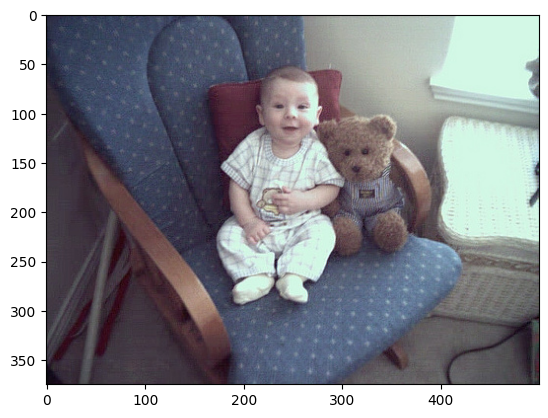

In [14]:
import IPython.display as ipd

def show_music_image(index):
    music_id = train_data.iloc[index]['music_id']
    image_id = train_data.iloc[index]['image_id']
    music_path = 'data/music/' + music_id + '.wav'
    image_path = 'data/images/' + image_id + '.jpg'

    music = ipd.Audio(music_path)
    image = plt.imread(image_path) 

    print(f'Similarity: {train_data.iloc[index]["matching"]}')
    ipd.display(music)
    plt.imshow(image)

index = np.random.randint(0, len(train_data))
show_music_image(index)

In [15]:
from music2ImageDataset import MusicImageDataset
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataset = MusicImageDataset(train_data)
val_dataset = MusicImageDataset(val_data)
test_dataset = MusicImageDataset(test_data)

Loading data: 100%|██████████| 7249/7249 [04:46<00:00, 25.31it/s]


In [131]:
from torch.utils.data import DataLoader, Subset

subset_size = 50
subset_indices = list(range(subset_size))

subset_dataset = Subset(train_dataset, subset_indices)

In [132]:
train_loader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [133]:
import torch
import torch.nn as nn
import wav2clip

class Music2ImageGenerator(nn.Module):
    def __init__(self, embedding_dim= 512):
        super().__init__()
        self.embedding = wav2clip.get_model()
        self.test = nn.ConvTranspose2d(embedding_dim, embedding_dim // 2, kernel_size=10, stride=6, padding=1),
        self.deconv = nn.Sequential( 
            nn.ConvTranspose2d(embedding_dim, embedding_dim // 2, kernel_size=16, stride=4, padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(embedding_dim // 2, embedding_dim // 4, kernel_size=16, stride=4, padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(embedding_dim // 4, 3, kernel_size=2, stride=4, padding=3), 
            nn.Tanh(), 
        )
    def forward(self, batch_audio):
        embedded = torch.stack([torch.tensor(wav2clip.embed_audio(audio, self.embedding)).reshape((-1, )) for audio in batch_audio])
        embedded = embedded.view(embedded.size(0), embedded.size(1), 1, 1)
        return self.deconv(embedded)


class FakeImageDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(32768, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x.reshape(-1, )


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dim = (256, 256)
generator = Music2ImageGenerator().to(device)
discriminator = FakeImageDiscriminator().to(device)

In [134]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
criterion = nn.BCELoss()

real_label = torch.FloatTensor(BATCH_SIZE).uniform_(0.9, 1).to(device)
fake_label = torch.FloatTensor(BATCH_SIZE).uniform_(0, 0.1).to(device)

In [135]:
for music, image in train_loader:
    print(music.shape, image.shape)
    out = generator(music)
    print(out.shape)
    break

torch.Size([32, 88200]) torch.Size([32, 256, 256, 3])
torch.Size([32, 3, 256, 256])


In [136]:
def train(epoch, train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion):
    generator.train()
    discriminator.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')

    G_losses = []
    D_losses = []

    D_accuracies = []

    for music, image in pbar:

        music = music.to(device)
        image = image.to(torch.float32).to(device)

        # Train discriminator on real images
        optimizer_D.zero_grad()
        image = image.reshape((-1, 3, 256, 256))
        D_real_output = discriminator(image)
        D_real_loss = criterion(D_real_output, real_label)

        # Train discriminator on fake images
        noise = torch.randn(BATCH_SIZE, *dim).to(device) # dim - image dimension
        fake_images = generator(music)
        D_fake_output = discriminator(fake_images.detach()) # detach to avoid training generator
        D_fake_loss = criterion(D_fake_output, fake_label)
        
        discriminator_loss = D_real_loss + D_fake_loss
        D_losses.append(discriminator_loss.item())

        D_accuracy = np.mean(D_real_output.cpu().detach().numpy() > 0.5)  
        D_accuracies.append(D_accuracy)

        discriminator_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        D_fake_output = discriminator(fake_images)
        G_loss = criterion(D_fake_output, real_label)
        G_losses.append(G_loss.item())

        G_loss.backward()
        optimizer_G.step()

        pbar.set_postfix({'Generator Loss': np.mean(G_losses), 'Discriminator Loss': np.mean(D_losses), 'Discriminator Accuracy': np.mean(D_accuracies)})

In [151]:
def evaluate(epoch, val_loader, generator, discriminator, criterion):
    generator.eval()
    discriminator.eval()

    G_losses = []
    D_losses = []

    D_accuracies = []

    pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    with torch.no_grad():
        for music, image in pbar:

            music = music.to(device)
            image = image.to(device)
            image = image.to(torch.float32)
            image = image.reshape((-1, 3, 256, 256))

            # Evaluate discriminator on real images
            D_real_output = discriminator(image)
            D_real_loss = criterion(D_real_output, real_label)

            # Evaluate discriminator on fake images
            noise = torch.randn(BATCH_SIZE, *dim).to(device)
            fake_images = generator(music)
            D_fake_output = discriminator(fake_images.detach())

            D_fake_loss = criterion(D_fake_output, fake_label)

            discriminator_loss = D_real_loss + D_fake_loss
            D_losses.append(discriminator_loss.item())

            D_accuracy = np.mean(D_real_output.cpu().detach().numpy() > 0.5)
            D_accuracies.append(D_accuracy)

            # Evaluate generator
            D_fake_output = discriminator(fake_images)
            G_loss = criterion(D_fake_output, real_label)
            G_losses.append(G_loss.item())

            pbar.set_postfix({'Generator Loss': np.mean(G_losses), 'Discriminator Loss': np.mean(D_losses), 'Discriminator Accuracy': np.mean(D_accuracies)})

    return np.mean(G_losses), np.mean(D_losses)

In [154]:
EPOCHS = 1
best_val_score = 1e9, 1e9

for epoch in range(EPOCHS):
    train(epoch, train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion)
    val_score = evaluate(epoch, val_loader, generator, discriminator, criterion)
    if val_score < best_val_score:
        best_val_score = val_score
        torch.save(generator.state_dict(), 'models/best_generator.pth')
        torch.save(discriminator.state_dict(), 'models/best_discriminator.pth')

Validation Epoch 0: 100%|██████████| 71/71 [01:59<00:00,  1.68s/it, Generator Loss=0.502, Discriminator Loss=5.55, Discriminator Accuracy=1]


torch.Size([32, 88200]) torch.Size([32, 256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256)


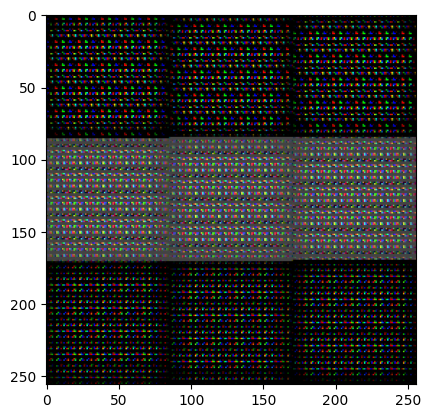

In [162]:
import time
i = 0

for music, image in train_loader:
    print(music.shape, image.shape)
    out = generator(music)
    out = out[0].detach().numpy()
    print(out.shape)
    plt.imshow(out.reshape(256, 256, 3))
    i += 1
    time.sleep(5)
    if i > 10:
        break